In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from gstatot import utils, StatOT
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [ ]:
# Download count matrix from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE189161

data_dir = '../../data/hemo_data/prefitted_adatas' # assumes count matrix is here 
metadata_path = './metadata' # required metadata already included in ./metadata

In [ ]:
adata = sc.read_mtx(f'{data_dir}/../GSE189161_matrix.mtx.gz')
adata = adata.T  # transpose to have cells as rows and genes as columns
cell_meta_data = pd.read_csv(f'{metadata_path}/GSE189161_metadata.csv', index_col=1)
cells = pd.read_csv(f'{metadata_path}/GSE189161_cells.txt', header=None)
genes = pd.read_csv(f'{metadata_path}/GSE189161_features.txt', header=None)

adata.obs_names = cells[0].values
adata.var_names = genes[0].values
adata.obs = cell_meta_data

adata.obs['age'] = pd.read_csv(f'{metadata_path}/ages.csv', index_col=0)
adata.obs['sink'] = pd.read_csv(f'{metadata_path}/sinks.csv', index_col=0)
adata.obs['sink_type'] = pd.read_csv(f'{metadata_path}/sink_types.csv', index_col=0).fillna('')

In [4]:
# prenatal data
prenatal_adata = adata[adata.obs['age'].str.contains('wk'), :].copy()
prenatal_adata.obs['age_wks'] = prenatal_adata.obs['age'].apply(lambda x: float(x.split('wk')[0]))

# postnatal data
postnatal_adata = adata[(adata.obs['age'].str.contains('yr')) | (adata.obs['age'].str.contains('CB')), :].copy()
postnatal_adata.obs['age_yrs'] = postnatal_adata.obs['age'].apply(lambda x: float(x.split('yr')[0]) if 'yr' in x else 0)


Min num cells in prenatal smoothed bin: 10901
Min num cells in postnatal smoothed bin: 11485


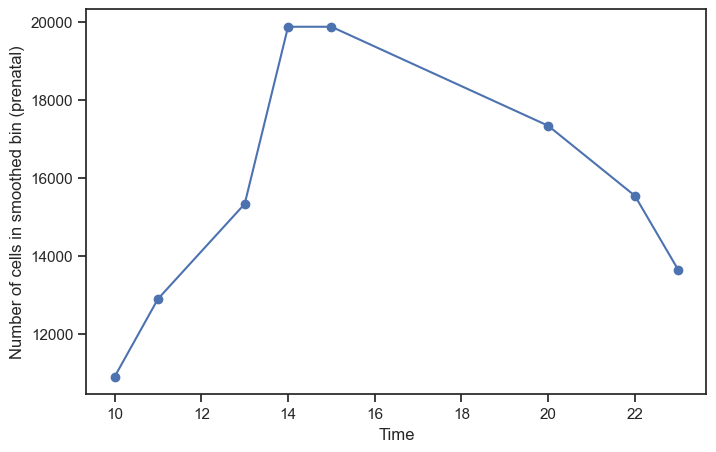

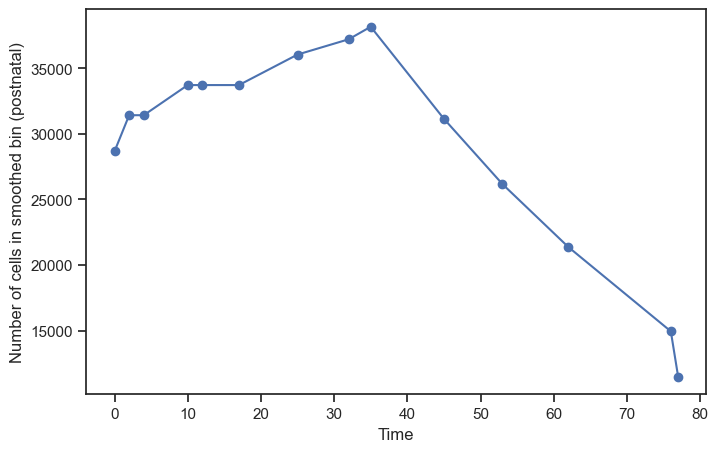

In [5]:
def triangle_kernel(t1, t2, h):
    return np.maximum(0, 1 - np.abs(t1 - t2) / h)

prenatal_times = np.unique(prenatal_adata.obs['age_wks'])

h_prenatal = 10
dists = np.zeros((len(prenatal_times), len(prenatal_times)))
for i, t1 in enumerate(prenatal_times):
    for j, t2 in enumerate(prenatal_times):
        k = triangle_kernel(t1, t2, h_prenatal)
        dists[i, j] = k
prenatal_dists = utils.row_normalize(dists)
prenatal_dists = pd.DataFrame(prenatal_dists, index=prenatal_times, columns=prenatal_times)


postnatal_times = np.unique(postnatal_adata.obs['age_yrs'])

h_postnatal = 45
dists = np.zeros((len(postnatal_times), len(postnatal_times)))
for i, t1 in enumerate(postnatal_times):
    for j, t2 in enumerate(postnatal_times):
        k = triangle_kernel(t1, t2, h_postnatal)
        dists[i, j] = k
postnatal_dists = utils.row_normalize(dists)
postnatal_dists = pd.DataFrame(postnatal_dists, index=postnatal_times, columns=postnatal_times)


num_cells_per_smoothed_bin = []
for t in prenatal_times:
    dist = prenatal_dists[t]
    nonzero_times = prenatal_times[dist > 0]
    prenatal_adata_t = prenatal_adata[prenatal_adata.obs['age_wks'].isin(nonzero_times)]
    num_cells_per_smoothed_bin.append(prenatal_adata_t.n_obs)

plt.figure(figsize=(8,5))
plt.plot(prenatal_times, num_cells_per_smoothed_bin, marker='o')
plt.xlabel('Time')
plt.ylabel('Number of cells in smoothed bin (prenatal)')
print('Min num cells in prenatal smoothed bin:', min(num_cells_per_smoothed_bin))

num_cells_per_smoothed_bin = []
for t in postnatal_times:
    dist = postnatal_dists[t]
    nonzero_times = postnatal_times[dist > 0]
    postnatal_adata_t = postnatal_adata[postnatal_adata.obs['age_yrs'].isin(nonzero_times)]
    num_cells_per_smoothed_bin.append(postnatal_adata_t.n_obs)

plt.figure(figsize=(8,5))
plt.plot(postnatal_times, num_cells_per_smoothed_bin, marker='o')
plt.xlabel('Time')
plt.ylabel('Number of cells in smoothed bin (postnatal)')
print('Min num cells in postnatal smoothed bin:', min(num_cells_per_smoothed_bin))

In [6]:
postnatal_times = np.unique(postnatal_adata.obs['age_yrs'])
prenatal_times = np.unique(prenatal_adata.obs['age_wks'])

prenatal_adata.obs['smoothed_age'] = np.nan
prenatal_obs = prenatal_adata.obs.copy()
prenatal_obs.sort_values(by='age_wks', inplace=True)
prenatal_adata = prenatal_adata[prenatal_obs.index].copy()

postnatal_adata.obs['smoothed_age'] = np.nan
postnatal_obs = postnatal_adata.obs.copy()
postnatal_obs.sort_values(by='age_yrs', inplace=True)
postnatal_adata = postnatal_adata[postnatal_obs.index].copy()

In [7]:
chosen_cells_prenatal = []
chosen_cells_times_prenatal = []

rng = np.random.default_rng(42)
for i, t_d in enumerate(prenatal_times):

    dist_t = prenatal_dists[t_d]
    full_dist = []
    for t in prenatal_times:

        full_dist.extend([dist_t[t]] * np.sum(prenatal_adata.obs['age_wks'] == t))

    full_dist = np.array(full_dist)

    full_dist = full_dist / full_dist.sum()
    chosen_inds_t = rng.choice(prenatal_adata.obs.index, size=10000, replace=True, p=full_dist)

    chosen_cells_prenatal.extend(chosen_inds_t)
    chosen_cells_times_prenatal.extend([t_d] * len(chosen_inds_t))


postnatal_adata.obs['smoothed_age'] = np.nan
chosen_cells_postnatal = []
chosen_cells_times_postnatal = []
for i, t_d in enumerate(postnatal_times):
    dist_t = postnatal_dists[t_d]
    full_dist = []
    for t in postnatal_times:
        full_dist.extend([dist_t[t]] * np.sum(postnatal_adata.obs['age_yrs'] == t))

    full_dist = np.array(full_dist)

    full_dist = full_dist / full_dist.sum()
    chosen_inds_t = rng.choice(postnatal_adata.obs.index, size=10000, replace=True, p=full_dist)


    chosen_cells_postnatal.extend(chosen_inds_t)
    chosen_cells_times_postnatal.extend([t_d] * len(chosen_inds_t))

In [8]:
prenatal_adata = prenatal_adata[chosen_cells_prenatal].copy()
prenatal_adata.obs['smoothed_age'] = np.array(chosen_cells_times_prenatal)
prenatal_adata.obs_names_make_unique()

postnatal_adata = postnatal_adata[chosen_cells_postnatal].copy()
postnatal_adata.obs['smoothed_age'] = np.array(chosen_cells_times_postnatal)
postnatal_adata.obs_names_make_unique()

/home/cole/coding/venvs/gstatot_py3.13_2/lib/python3.13/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/cole/coding/venvs/gstatot_py3.13_2/lib/python3.13/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
dt = 0.25
sink_growth = 1e-5


def apply_growth_rates(adata, ages, sink_growth, dt, time_key='age_yrs'):
    adata.obs['growth'] = 1.0
    adata.obs['growth_rate'] = 0.0
    sink_gr = np.log(sink_growth) / dt

    for a in ages:
        order_ind = (adata.obs[time_key] == a)
        sink_ind = order_ind & (adata.obs['sink'] == True)

        adata.obs.loc[sink_ind, 'growth'] = sink_growth
        adata.obs.loc[sink_ind, 'growth_rate']  = sink_gr

        G = adata.obs.loc[order_ind, 'growth'].values
        G = G / G.sum() * np.sum(order_ind)
        GR = np.log(G) / dt
        print("source growth rate: ", GR[GR>0][0])
        adata.obs.loc[order_ind, 'growth_rate'] = GR
        adata.obs.loc[order_ind, 'growth'] = G


apply_growth_rates(prenatal_adata, prenatal_times, sink_growth, dt, time_key='age_wks')
apply_growth_rates(postnatal_adata, postnatal_times, sink_growth, dt, time_key='age_yrs')

source growth rate:  0.16536926769862942
source growth rate:  0.24162120158677977
source growth rate:  0.24800659885729315
source growth rate:  0.1869140073456547
source growth rate:  0.18194989008281867
source growth rate:  0.19838573065970103
source growth rate:  0.1777020928138921
source growth rate:  0.17399804421173032
source growth rate:  0.11503323498184297
source growth rate:  0.33238214366616764
source growth rate:  0.10467008661734346
source growth rate:  0.22783915316406697
source growth rate:  0.16159749638342996
source growth rate:  0.5743956988216491
source growth rate:  0.13097505643045543
source growth rate:  0.11031266352565733
source growth rate:  0.1867909917385364
source growth rate:  0.14388720855400056
source growth rate:  0.17672984862781507
source growth rate:  0.34883391200385544
source growth rate:  0.3428294324491957
source growth rate:  0.4133465153446579


In [10]:
# prenatal 
sc.pp.normalize_total(prenatal_adata, target_sum=1e4)
sc.pp.log1p(prenatal_adata)
sc.pp.pca(prenatal_adata, n_comps=50)

# postnatal
sc.pp.normalize_total(postnatal_adata, target_sum=1e4)
sc.pp.log1p(postnatal_adata)
sc.pp.pca(postnatal_adata, n_comps=50)


# Ground truth estimation

In [11]:
adata_keys  = {'time_key': 'smoothed_age',
               'cell_type_key': 'sink_type',
               'growth_rate_key': 'growth_rate',
               'embed_key': 'X_pca'}

sOT_params = {'epsilon': 0.025,
              'lse': True,
              'cost_scaling': 'mean'}

In [12]:
sOT_prenatal = StatOT(adata=prenatal_adata, adata_keys=adata_keys, dt=dt, dtype=jnp.float32)

sOT_prenatal.fit(model_params=sOT_params, max_iter=5_000, verbose=True)

sOT_prenatal.get_lin_fate_probs(label_key=adata_keys['cell_type_key'], 
                                all_labels=np.unique(prenatal_adata.obs['sink_type']))

Cost scaled by  mean
Time 10.0, ran 5000 iterations, inf norm error: 7.4870e-09
Time 11.0, ran 5000 iterations, inf norm error: 7.9017e-09
Time 13.0, ran 5000 iterations, inf norm error: 7.9526e-09
Time 14.0, ran 5000 iterations, inf norm error: 1.3861e-08
Time 15.0, ran 5000 iterations, inf norm error: 2.0882e-09
Time 20.0, ran 5000 iterations, inf norm error: 2.3370e-08
Time 22.0, ran 5000 iterations, inf norm error: 6.5935e-08
Time 23.0, ran 5000 iterations, inf norm error: 8.5034e-08


Age 10.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 3.92 %
 Coverage: 91.65 %
Age 11.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 4.32 %
 Coverage: 90.65 %
Age 13.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 4.10 %
 Coverage: 88.65 %
Age 14.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 4.20 %
 Coverage: 87.90 %
Age 15.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 5.18 %
 Coverage: 88.62 %
Age 20.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 4.67 %
 Coverage: 91.08 %
Age 22.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of particles that did not reach sink: 5.68 %
 Coverage: 91.00 %
Age 23.0 : Steps to reach sink
Length of flows: 65 steps
Percentage of parti

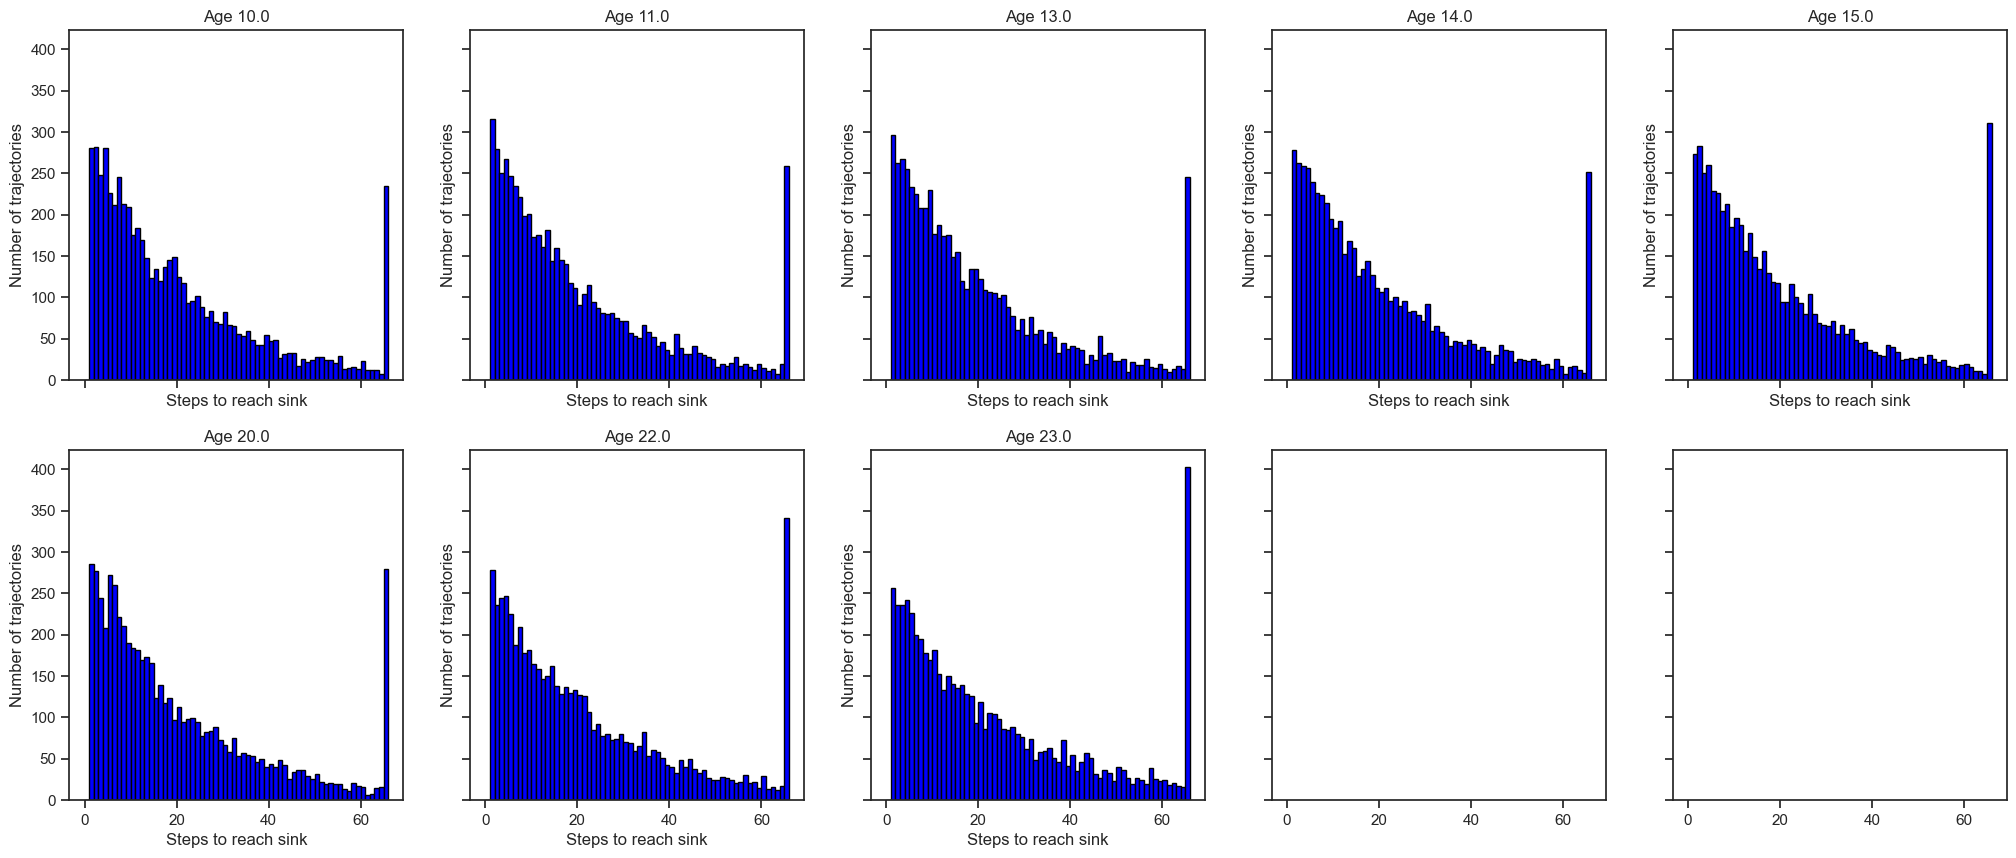

In [13]:
sOT_prenatal.get_trajectories(num_step=65, num_traj=6000, plot_hitting_time=True)

In [14]:
sOT_prenatal.adata.write_h5ad(f'{data_dir}/prenatal_statOT_fitted.h5ad')

In [15]:
sOT_postnatal = StatOT(adata=postnatal_adata, adata_keys=adata_keys, dt=dt, dtype=jnp.float32)
sOT_postnatal.fit(model_params=sOT_params, max_iter=5_000, verbose=True)

sOT_postnatal.get_lin_fate_probs(label_key=adata_keys['cell_type_key'], 
                                all_labels=np.unique(postnatal_adata.obs['sink_type']))

Cost scaled by  mean
Time 0.0, ran 5000 iterations, inf norm error: 3.6380e-10
Time 2.0, ran 5000 iterations, inf norm error: 3.1287e-10
Time 4.0, ran 5000 iterations, inf norm error: 3.4925e-10
Time 10.0, ran 5000 iterations, inf norm error: 2.9831e-10
Time 12.0, ran 5000 iterations, inf norm error: 3.5652e-10
Time 17.0, ran 5000 iterations, inf norm error: 3.2014e-10
Time 25.0, ran 5000 iterations, inf norm error: 3.2014e-10
Time 32.0, ran 5000 iterations, inf norm error: 2.9831e-10
Time 35.0, ran 5000 iterations, inf norm error: 4.1473e-10
Time 45.0, ran 5000 iterations, inf norm error: 2.9831e-10
Time 53.0, ran 5000 iterations, inf norm error: 3.0559e-10
Time 62.0, ran 5000 iterations, inf norm error: 4.0018e-10
Time 76.0, ran 5000 iterations, inf norm error: 1.3679e-09
Time 77.0, ran 5000 iterations, inf norm error: 2.0227e-09


Age 0.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 5.64 %
 Coverage: 92.53 %
Age 2.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 7.56 %
 Coverage: 91.57 %
Age 4.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 6.46 %
 Coverage: 92.29 %
Age 10.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 5.46 %
 Coverage: 92.14 %
Age 12.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 5.16 %
 Coverage: 91.81 %
Age 17.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 5.75 %
 Coverage: 90.89 %
Age 25.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particles that did not reach sink: 5.71 %
 Coverage: 90.90 %
Age 32.0 : Steps to reach sink
Length of flows: 80 steps
Percentage of particle

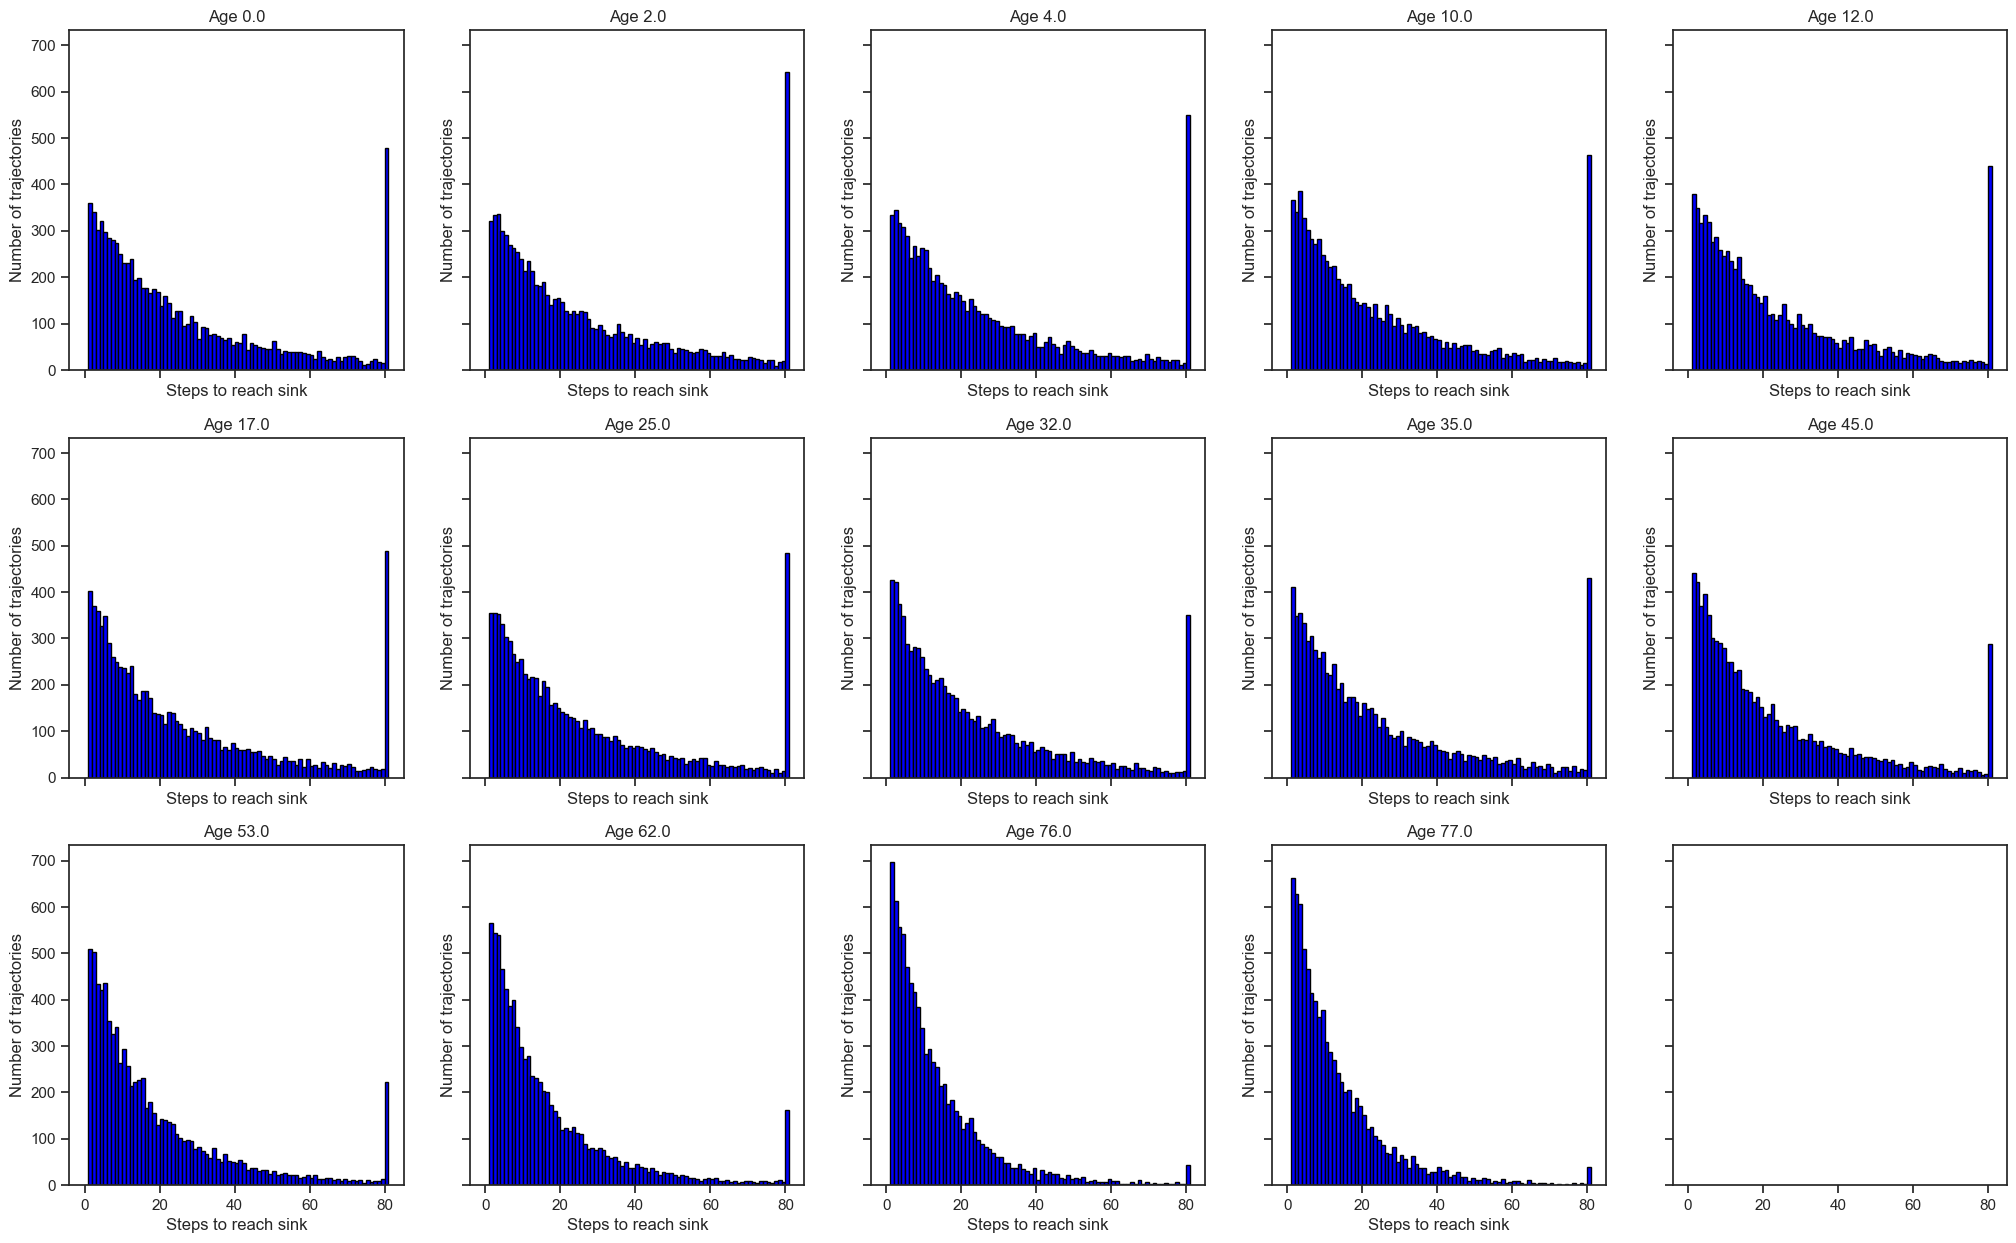

In [16]:
sOT_postnatal.get_trajectories(num_step=80, num_traj=8500, plot_hitting_time=True)

In [17]:
sOT_postnatal.adata.write_h5ad(f'{data_dir}/postnatal_statOT_fitted.h5ad')